# Project: **Finding Lane Lines on the Road** 
***
---
**Tools available**
* Color selection
* Region of interest selection 
* Grayscaling,
* Gaussian smoothing
* Canny Edge Detection
* Hough Tranform line detection
---
**Goal:** Piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).



---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


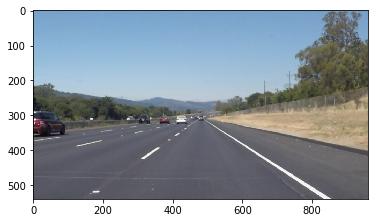

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [105]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def getSlope(line):
    """
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line. Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    """
    for x1,y1,x2,y2 in line:
        slope = (y2-y1)/(x2-x1)
        #print(x1,y1,x2,y2,slope)
        return slope

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        #print(line)
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img,lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)
def calculateLines(lines,x1R,x1L):
    """
    lines is the output of the hough_lines()
    x1R is the x pixel where the right line ends/starts
    1L is the x pixel where the left line starts/ends
    
    It splits the lines into right lane and left lane.
    Then computes the best fit straight that fits all side straights
    It returns the two lines to be drown by its 4 points
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    # Categorize lines by slope
    thresholdSlope = 0;

    xR = []
    yR = []
    xL = []
    yL = []

    for line in lines:
        x1,y1,x2,y2 = line[0];
        currentSlope = getSlope(line);
        if (currentSlope > thresholdSlope and x1 > limitUR[0] and x2 > limitUL[0]):
        # Its a right line
            if y1>y2:
                x1,x2 = x2,x1
                y1,y2 = y2,y1
            xR += [x1, x2]
            yR += [y1, y2]
        elif (currentSlope < -thresholdSlope and x1 < limitUL[0] and x2 < limitUL[0] ):
        # Its a left line
            xL += [x1, x2]
            yL += [y1, y2]

    try:
        zR = np.polyfit(xR, yR, 1)
        zL = np.polyfit(xL, yL, 1)
        fR = np.poly1d(zR)
        fL = np.poly1d(zL)
        mR, bR = zR
        mL, bL = zL

        return [[[int(x1R),int(fR(x1R)), 960, int(fR(960))],
                 [0,int(fL(0)), int(x1L),  int(fL(x1L))]]]
    except:
        return [[[0,0, 0, 0],
                 [0,0,0,0]]]

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [106]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


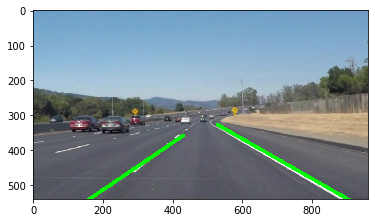

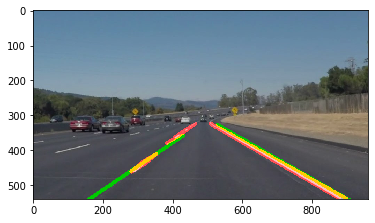

In [107]:
# Read in the image and print out some stats
images_list = os.listdir("test_images/");

image_path = 'test_images/' + images_list[0]
image_base = mpimg.imread(image_path)
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]

# Convert to Gray scale
imageGray = grayscale(image_base)

#plt.figure()
#plt.imshow(imageGray, cmap='gray')


# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
imgCanny = cv2.Canny(imageGray, low_threshold, high_threshold)

#plt.figure()
#plt.imshow(imgCanny, cmap='gray')

#Apply region of interest
width = 0.05;
height = 0.60;

limitLL = (0,ysize);
limitLR = (xsize,ysize);
limitUL = (xsize/2-xsize*width, ysize*height);
limitUR = (xsize/2+xsize*width, ysize*height);


vertices = np.array([[limitLL,limitUL,limitUR , limitLR]], dtype=np.int32)
imgROI = region_of_interest(imgCanny, vertices)

#plt.figure()
#plt.imshow(imgROI, cmap='gray')

# Define a kernel size and apply Gaussian smoothing
kernel_size = 7
imgBlur = cv2.GaussianBlur(imgROI,(kernel_size, kernel_size),0)

#plt.figure()
#plt.imshow(imgBlur, cmap='gray')

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = 60*np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20   # maximum gap in pixels between connectable line segments

imgHouhg,lines = hough_lines(imgBlur, rho, theta, threshold, min_line_len, max_line_gap)

lines = calculateLines(lines,limitUR[0],limitUL[0])

#plt.figure()
#plt.imshow(imgHouhg)

draw_lines(image_base, lines, color=[0, 255, 0], thickness=10)

plt.figure()
plt.imshow(image_base)


imgWeight = weighted_img(imgHouhg, image_base, α=0.8, β=1., γ=0.)

plt.figure()
plt.imshow(imgWeight)

# Helper funtion to understand how line detection works

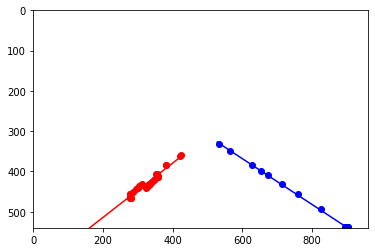

In [141]:
imgHouhg,lines = hough_lines(imgBlur, rho, theta, threshold, min_line_len, max_line_gap)

# Categorize lines by slope
thresholdSlope = 0;

xR = []
yR = []
xL = []
yL = []

for line in lines:
    x1,y1,x2,y2 = line[0];
    currentSlope = getSlope(line);
    if (currentSlope > thresholdSlope and x1 > limitUR[0] and x2 > limitUL[0]):
    # Its a right line
        if y1>y2:
            x1,x2 = x2,x1
            y1,y2 = y2,y1
        xR += [x1, x2]
        yR += [y1, y2]
    elif (currentSlope < -thresholdSlope and x1 < limitUL[0] and x2 < limitUL[0] ):
    # Its a left line
        xL += [x1, x2]
        yL += [y1, y2]

zR = np.polyfit(xR, yR, 1)
zL = np.polyfit(xL, yL, 1)
fR = np.poly1d(zR)
fL = np.poly1d(zL)
mR, bR = zR
mL, bL = zL


for x1, y1 in zip(xL, yL):
    plt.plot(x1, y1, 'ro')
for x1, y1 in zip(xR, yR):
    plt.plot(x1, y1, 'bo')
    
plt.plot((limitUR[0], 960), (fR(limitUR[0]), fR(960)), 'b')
plt.plot((0, limitUL[0]), (fL(0), fL(limitUL[0])), 'r')


plt.axis([0, 960, 0, 540])
plt.yticks(rotation=0)
plt.xticks(rotation=0)

# Set origin in upper left
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis

plt.show()

#print(lines)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [109]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [132]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)    


    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]

    # Convert to Gray scale
    imageGray = grayscale(image)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 150
    imgCanny = cv2.Canny(imageGray, low_threshold, high_threshold)

    #Apply region of interest
    width = 0.02;
    height = 0.60;
    discoutnBottom = 50;
    discoutnBottomSides = 50;

    limitLL = (discoutnBottomSides,ysize-discoutnBottom);
    limitLR = (xsize-discoutnBottomSides,ysize-discoutnBottom);
    limitUL = (xsize/2-xsize*width, ysize*height);
    limitUR = (xsize/2+xsize*width, ysize*height);

    vertices = np.array([[limitLL,limitUL,limitUR , limitLR]], dtype=np.int32)
    imgROI = region_of_interest(imgCanny, vertices)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 7
    imgBlur = cv2.GaussianBlur(imgROI,(kernel_size, kernel_size),0)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = 60*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20   # maximum gap in pixels between connectable line segments

    imgHouhg,lines = hough_lines(imgBlur, rho, theta, threshold, min_line_len, max_line_gap)

    lines = calculateLines(lines,limitUR[0],limitUL[0])


    draw_lines(imgHouhg, lines, color=[0, 255, 0], thickness=10)

    
    imgWeight = weighted_img(imgHouhg, image, α=0.8, β=1., γ=0.)

    return imgWeight

Let's try the one with the solid white lane on the right first ...

In [136]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.







t:  23%|███████████████▍                                                   | 157/681 [31:26<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [19:24<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [36:24<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:44<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:52<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [35:56<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [31:08<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:53<00:06, 19.54it/s, now=None

Moviepy - Writing video test_videos_output/solidWhiteRight.mp4








t:  23%|███████████████▍                                                   | 157/681 [31:26<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [19:24<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [36:24<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:44<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:53<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [35:56<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [31:09<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:54<00:06, 19.54it/s, now=None

Moviepy - Done !







t:  23%|███████████████▍                                                   | 157/681 [31:31<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [19:28<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [36:29<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:49<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:57<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [36:00<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [31:13<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:58<00:06, 19.54it/s, now=None

Moviepy - video ready test_videos_output/solidWhiteRight.mp4







t:  23%|███████████████▍                                                   | 157/681 [31:31<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [19:28<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [36:29<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:49<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:57<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [36:01<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [31:13<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:58<00:06, 19.54it/s, now=None

Wall time: 4.68 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [134]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [135]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.







t:  23%|███████████████▍                                                   | 157/681 [30:48<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [18:45<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [35:46<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:06<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:14<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [35:18<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [30:30<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:15<00:06, 19.54it/s, now=None

Moviepy - Writing video test_videos_output/solidYellowLeft.mp4








t:  23%|███████████████▍                                                   | 157/681 [30:48<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [18:45<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [35:46<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:06<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:14<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [35:18<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [30:30<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:15<00:06, 19.54it/s, now=None

Moviepy - Done !







t:  23%|███████████████▍                                                   | 157/681 [30:52<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [18:49<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [35:50<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:10<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:18<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [35:22<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [30:34<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:19<00:06, 19.54it/s, now=None

Moviepy - video ready test_videos_output/solidYellowLeft.mp4







t:  23%|███████████████▍                                                   | 157/681 [30:52<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [18:49<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [35:50<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [40:10<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [37:18<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [35:22<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [30:34<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [30:19<00:06, 19.54it/s, now=None

Wall time: 4.08 s


In [137]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [138]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.







t:  23%|███████████████▍                                                   | 157/681 [32:33<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [20:30<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [37:30<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [41:51<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [38:59<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [37:02<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [32:15<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [32:00<00:06, 19.54it/s, now=None

Moviepy - Writing video test_videos_output/challenge.mp4








t:  23%|███████████████▍                                                   | 157/681 [32:33<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [20:30<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [37:31<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [41:51<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [38:59<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [37:02<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [32:15<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [32:00<00:06, 19.54it/s, now=None

Moviepy - Done !







t:  23%|███████████████▍                                                   | 157/681 [32:40<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [20:37<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [37:38<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [41:58<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [39:06<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [37:10<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [32:22<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [32:07<00:06, 19.54it/s, now=None

Moviepy - video ready test_videos_output/challenge.mp4







t:  23%|███████████████▍                                                   | 157/681 [32:40<00:22, 23.69it/s, now=None]











t:   4%|██▊                                                                  | 9/221 [20:37<00:38,  5.48it/s, now=None]


t:  23%|███████████████▍                                                   | 157/681 [37:38<00:12, 43.40it/s, now=None]









t:  23%|███████████████▍                                                   | 157/681 [41:58<00:07, 68.89it/s, now=None]

t:  23%|███████████████▍                                                   | 157/681 [39:06<00:10, 51.31it/s, now=None]



t:  51%|██████████████████████████████████▏                                | 128/251 [37:10<00:04, 25.51it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [32:22<00:05, 20.75it/s, now=None]






t:  51%|██████████████████████████████████▏                                | 128/251 [32:07<00:06, 19.54it/s, now=None

Wall time: 7.42 s


In [1]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

NameError: name 'HTML' is not defined

## Improvements:

- Try to fit to a curve instead of a straight
- Improve image processing specially of shadows 
- Left line tends to tighten
- Lines have differnt height